# Fitted Q-iteration

In [1]:
import numpy as np
import pandas as pd
from scipy.stats import norm
import random

import sys

sys.path.append("..")

import time
import matplotlib.pyplot as plt


In [2]:
# parameters for MC simulation of stock prices

S0 = 100      # initial stock price
mu = 0.05     # drift
sigma = 0.15  # volatility
r = 0.03      # risk-free rate
M = 1         # maturity
T = 6        # number of time steps

N_MC = 10000 # 10000 # 50000   # number of paths

delta_t = M / T                # time interval
gamma = np.exp(- r * delta_t)  # discount factor



Time Cost: 0.040656089782714844 seconds


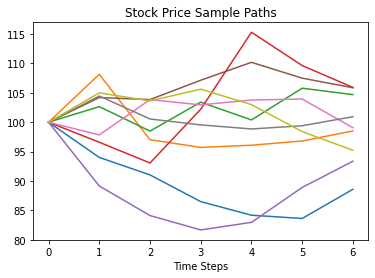

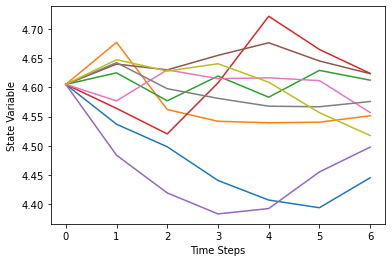

In [4]:
# generate a dataset
starttime = time.time()
np.random.seed(42) # Fix random seed
# stock price
S = pd.DataFrame([], index=range(1, N_MC+1), columns=range(T+1))
S.loc[:,0] = S0

# standard normal random numbers
RN = pd.DataFrame(np.random.randn(N_MC,T), index=range(1, N_MC+1), columns=range(1, T+1))

for t in range(1, T+1):
    S.loc[:,t] = S.loc[:,t-1] * np.exp((mu - 1/2 * sigma**2) * delta_t + sigma * np.sqrt(delta_t) * RN.loc[:,t])

delta_S = S.loc[:,1:T].values - np.exp(r * delta_t) * S.loc[:,0:T-1]
delta_S_hat = delta_S.apply(lambda x: x - np.mean(x), axis=0)

# state variable
X = - (mu - 1/2 * sigma**2) * np.arange(T+1) * delta_t + np.log(S)   # delta_t here is due to their conventions

endtime = time.time()
print('\nTime Cost:', endtime - starttime, 'seconds')

# plot 10 paths
step_size = N_MC // 10
idx_plot = np.arange(step_size, N_MC, step_size)
plt.plot(S.T.iloc[:, idx_plot])
plt.xlabel('Time Steps')
plt.title('Stock Price Sample Paths')
plt.show()

plt.plot(X.T.iloc[:, idx_plot])
plt.xlabel('Time Steps')
plt.ylabel('State Variable')
plt.show()


In [5]:
# function to compute final (terminal) payoff
def terminal_payoff(ST, K):
    # ST   final stock price
    # K    strike
    payoff = max(K-ST, 0)
    return payoff


X.shape =  (10000, 7)
X_min, X_max =  4.057527970756566 5.162066529170717
Number of points k =  17


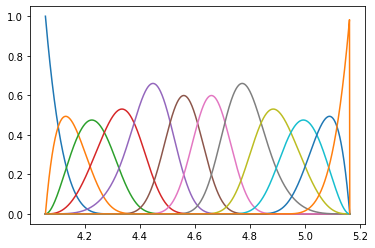

<Figure size 432x288 with 0 Axes>

In [7]:
# define a spline basis function
# this part is directly copied from QLBS 
import bspline
import bspline.splinelab as splinelab
X_min = np.min(np.min(X))
X_max = np.max(np.max(X))

print('X.shape = ', X.shape)
print('X_min, X_max = ', X_min, X_max)

p = 4       
ncolloc = 12
tau = np.linspace(X_min,X_max,ncolloc)  

k = splinelab.aptknt(tau, p) 
basis = bspline.Bspline(k, p)        
f = plt.figure()

print('Number of points k = ', len(k))
basis.plot()

plt.savefig('Basis_functions.png', dpi=600)


In [8]:
# generate data
num_t_steps = T + 1
num_basis =  ncolloc # len(k) #

data_mat_t = np.zeros((num_t_steps, N_MC,num_basis ))

print('num_basis = ', num_basis)
print('dim data_mat_t = ', data_mat_t.shape)

# fill it, expand function in finite dimensional space
# in neural network the basis is the neural network itself
t_0 = time.time()
for i in np.arange(num_t_steps):
    x = X.values[:,i]
    data_mat_t[i,:,:] = np.array([ basis(el) for el in x ])
 
t_end = time.time()
print('Computational time:', t_end - t_0, 'seconds')

np.save('data_mat_m=r_A_%d' % N_MC, data_mat_t)



num_basis =  12
dim data_mat_t =  (7, 10000, 12)
Computational time: 6.779400110244751 seconds


In [9]:
# parameters in the model
risk_lambda = 0.001 # 0.001 # 0.0001            # risk aversion
K = 100 # 


# 1 functions to compute optimal hedges

In [12]:
# functions to compute optimal hedges
def function_A_vec(t, delta_S_hat, data_mat, reg_param):
    X_mat = data_mat[t, :, :]
    num_basis_funcs = X_mat.shape[1]
    this_dS = delta_S_hat.loc[:, t]
    hat_dS2 = (this_dS ** 2).values.reshape(-1, 1)
    A_mat = np.dot(X_mat.T, X_mat * hat_dS2) + reg_param * np.eye(num_basis_funcs)
    
    return A_mat

def function_B_vec(t,
                   Pi_hat, 
                   delta_S_hat=delta_S_hat,
                   S=S,
                   data_mat=data_mat_t,
                   gamma=gamma,
                   risk_lambda=risk_lambda):
    coef = 0.
    tmp = Pi_hat.loc[:,t+1] * delta_S_hat.loc[:, t]
    X_mat = data_mat[t, :, :]
    B_vec = np.dot(X_mat.T, tmp)
    
    return B_vec

In [13]:
# Use the A_matrix and B_vec to compute the optimal hedge and portfolio value
starttime = time.time()

# portfolio value
Pi = pd.DataFrame([], index=range(1, N_MC+1), columns=range(T+1))
Pi.iloc[:,-1] = S.iloc[:,-1].apply(lambda x: terminal_payoff(x, K))

Pi_hat = pd.DataFrame([], index=range(1, N_MC+1), columns=range(T+1))
Pi_hat.iloc[:,-1] = Pi.iloc[:,-1] - np.mean(Pi.iloc[:,-1])

# optimal hedge
a = pd.DataFrame([], index=range(1, N_MC+1), columns=range(T+1))
a.iloc[:,-1] = 0

reg_param = 1e-3
for t in range(T-1, -1, -1):
    A_mat = function_A_vec(t, delta_S_hat, data_mat_t, reg_param)
    B_vec = function_B_vec(t, Pi_hat, delta_S_hat, S, data_mat_t)

    # print ('t =  A_mat.shape = B_vec.shape = ', t, A_mat.shape, B_vec.shape)
    phi = np.dot(np.linalg.inv(A_mat), B_vec)

    a.loc[:,t] = np.dot(data_mat_t[t,:,:],phi)
    Pi.loc[:,t] = gamma * (Pi.loc[:,t+1] - a.loc[:,t] * delta_S.loc[:,t])
    Pi_hat.loc[:,t] = Pi.loc[:,t] - np.mean(Pi.loc[:,t])

a = a.astype('float')
Pi = Pi.astype('float')
Pi_hat = Pi_hat.astype('float')
endtime = time.time()
print('Computational time:', endtime - starttime, 'seconds')



Computational time: 0.05602002143859863 seconds


# 2 Compute the optimal Q-function witt dynamic programming 

In [15]:
def function_C_vec(t, data_mat, reg_param):
    X_mat = data_mat[t, :, :]
    num_basis_funcs = X_mat.shape[1]
    C_mat = np.dot(X_mat.T, X_mat) + reg_param * np.eye(num_basis_funcs)  
    
    return C_Mat

def function_D_vec(t, Q, R, data_mat, gamma=gamma):
    X_mat = data_mat[t, :, :]
    D_vec = np.dot(X_mat.T, R.loc[:,t] + gamma * Q.loc[:, t+1])
    
    return D_vec


# BS pricing strategies
def bs_put(t, S0=S0, K=K, r=r, sigma=sigma, T=M):
    d1 = (np.log(S0/K) + (r + 1/2 * sigma**2) * (T-t)) / sigma / np.sqrt(T-t)
    d2 = (np.log(S0/K) + (r - 1/2 * sigma**2) * (T-t)) / sigma / np.sqrt(T-t)
    price = K * np.exp(-r * (T-t)) * norm.cdf(-d2) - S0 * norm.cdf(-d1)
    return price

def bs_call(t, S0=S0, K=K, r=r, sigma=sigma, T=M):
    d1 = (np.log(S0/K) + (r + 1/2 * sigma**2) * (T-t)) / sigma / np.sqrt(T-t)
    d2 = (np.log(S0/K) + (r - 1/2 * sigma**2) * (T-t)) / sigma / np.sqrt(T-t)
    price = S0 * norm.cdf(d1) - K * np.exp(-r * (T-t)) * norm.cdf(d2)
    return price

In [17]:
# compute hedging and pricing with RL 
eta = 0.5 #  change the ete with value ofreg_param = 1e-3
np.random.seed(42) # Fix random seed
0.5 # 0.25 # 0.05 # 0.5 # 0.1 # 0.25 # 0.15

# disurbed optimal actions to be computed
a_op = pd.DataFrame([], index=range(1, N_MC+1), columns=range(T+1))
a_op.iloc[:,-1] = 0

# portfolio value 
Pi_op = pd.DataFrame([], index=range(1, N_MC+1), columns=range(T+1))
Pi_op.iloc[:,-1] = S.iloc[:,-1].apply(lambda x: terminal_payoff(x, K))

Pi_op_hat = pd.DataFrame([], index=range(1, N_MC+1), columns=range(T+1))
Pi_op_hat.iloc[:,-1] = Pi_op.iloc[:,-1] - np.mean(Pi_op.iloc[:,-1])

# reward function
R_op = pd.DataFrame([], index=range(1, N_MC+1), columns=range(T+1))
R_op.iloc[:,-1] = - risk_lambda * np.var(Pi_op.iloc[:,-1])

# the backward loop
for t in range(T-1, -1, -1):
    
    # 1. compute the optimal policy, and write the result t a_op
    a_op.loc[:, t] = a.loc[:, t]
    # 2. disturb these values by a random noise (note that here we use multiplicaiton model, you can also use addition model, both can be 
    # solved in linear systems. Sometimes addition models can yield better solution, but here multiplicaiton performs better)
    a_op.loc[:, t] *= np.random.uniform(1 - eta, 1 + eta, size=a_op.shape[0])
    
    ## note that 3 and 4 are observation-based values, so error need to be addressed with simulations
    # 3. Compute portfolio values corresponding to observed actions
    Pi_op.loc[:,t] = gamma * (Pi_op.loc[:,t+1] - a_op.loc[:,t] * delta_S.loc[:,t])
    Pi_hat.loc[:,t] = Pi_op.loc[:,t] - np.mean(Pi_op.loc[:,t])

    # 4. compute rewards corresponding to observed actions
    R_op.loc[:,t] = gamma * a_op.loc[:,t] * delta_S.loc[:,t] - risk_lambda * np.var(Pi_op.loc[:,t])

print('done with backward loop!')


done with backward loop!


# Now let's do some simulation

In [19]:
np.random.seed(42)
idx_row = np.random.randint(low=0, high=R_op.shape[0], size=10)

np.random.seed(42)
idx_col = np.random.randint(low=0, high=R_op.shape[1], size=10)

part_1 = list(R_op.loc[idx_row, idx_col].values.flatten())
try:
    part1 = " ".join(map(repr, part_1))
except TypeError:
    part1 = repr(part_1)

R_op.loc[idx_row, idx_col].values.flatten()


array([-4.41648229e-02, -1.11627835e+00, -3.26618627e-01, -4.41648229e-02,
        1.86629772e-01, -3.26618627e-01, -3.26618627e-01, -4.41648229e-02,
       -1.91643174e+00,  1.86629772e-01, -4.41648229e-02, -1.15471981e+01,
        8.36214406e-03, -4.41648229e-02, -5.19860756e-01,  8.36214406e-03,
        8.36214406e-03, -4.41648229e-02, -5.82629891e-02, -5.19860756e-01,
       -4.41648229e-02, -2.93024596e+00, -6.70591047e-01, -4.41648229e-02,
        3.38303735e-01, -6.70591047e-01, -6.70591047e-01, -4.41648229e-02,
       -1.35776224e-01,  3.38303735e-01, -4.41648229e-02,  3.89179538e-02,
       -2.11256164e+00, -4.41648229e-02, -8.62139383e-01, -2.11256164e+00,
       -2.11256164e+00, -4.41648229e-02,  1.03931641e+00, -8.62139383e-01,
       -4.41648229e-02, -3.88581528e+00, -2.78664643e-01, -4.41648229e-02,
        1.08026845e+00, -2.78664643e-01, -2.78664643e-01, -4.41648229e-02,
       -1.59815566e-01,  1.08026845e+00, -4.41648229e-02,  1.34127261e+00,
       -1.32542466e+00, -

# 3 Override on-policy data with off-policy data


In [30]:
a = a_op.copy()      # distrubed actions
Pi = Pi_op.copy()    # disturbed portfolio values
Pi_hat = Pi_op_hat.copy()
R = R_op.copy()

# make matrix A_t of shape (3 x num_MC x num_steps)
num_MC = a.shape[0] # number of simulated paths
num_TS = a.shape[1] # number of time steps
a_1_1 = a.values.reshape((1, num_MC, num_TS))

a_1_2 = 0.5 * a_1_1**2
ones_3d = np.ones((1, num_MC, num_TS))

A_stack = np.vstack((ones_3d, a_1_1, a_1_2))

data_mat_swap_idx = np.swapaxes(data_mat_t,0,2)

# expand dimensions of matrices to multiply element-wise
A_2 = np.expand_dims(A_stack, axis=1) # becomes (3,1,10000,25)
data_mat_swap_idx = np.expand_dims(data_mat_swap_idx, axis=0)  # becomes (1,12,10000,25)

Psi_mat = np.multiply(A_2, data_mat_swap_idx) # this is a matrix of size 3 x num_basis x num_MC x num_steps

# now concatenate columns along the first dimension
# Psi_mat = Psi_mat.reshape(-1, a.shape[0], a.shape[1], order='F')
Psi_mat = Psi_mat.reshape(-1, N_MC, T+1, order='F')


In [23]:
# compute the matrix S_t with disturbed noise and off-policy data

Psi_1_aux = np.expand_dims(Psi_mat, axis=1)
Psi_2_aux = np.expand_dims(Psi_mat, axis=0)
print(Psi_1_aux.shape, Psi_2_aux.shape)

S_t_mat = np.sum(np.multiply(Psi_1_aux, Psi_2_aux), axis=2) 

print(S_t_mat.shape)


(36, 1, 10000, 7) (1, 36, 10000, 7)
(36, 36, 7)


# 4 Calculate St and Mt matreix and vector

In [32]:
# note that we have to vectorize the data in order to use underlying parallel mechanism of python
# if mistakenly use scalar function, you may have to spend more than 100x time
def function_S_vec(s, S_t_mat, reg_param):
    num_Qbasis = S_t_mat.shape[0]
    S_mat_reg = S_t_mat[:,:,t] + reg_param * np.eye(num_Qbasis)
    
    return S_mat_reg

def function_M_vec(t,
                   Q_star, 
                   R, 
                   Psi_mat_t, gamma=gamma):
  
    # note that numpy has intrinsic parallelism for the dot product
    M_t = np.dot(Psi_mat_t, R.loc[:,t] + gamma * Q_star.loc[:, t+1])
    
    return M_t

In [27]:
# simulation and test without RL
reg_param = 1e-3
np.random.seed(42)
S_mat_reg = function_S_vec(T-1, S_t_mat, reg_param) 
idx_row = np.random.randint(low=0, high=S_mat_reg.shape[0], size=10)

np.random.seed(42)
idx_col = np.random.randint(low=0, high=S_mat_reg.shape[1], size=10)

part_3 = list(S_mat_reg[idx_row, idx_col].flatten())
try:
    part3 = " ".join(map(repr, part_3))
except TypeError:
    part3 = repr(part_3)
    
S_mat_reg[idx_row, idx_col].flatten()


array([1.00000000e-03, 1.79444993e-01, 1.00000000e-03, 1.35535573e+01,
       1.89060180e+03, 1.77933469e+00, 1.00000003e-03, 1.00000003e-03,
       8.63282221e-02, 1.00000000e-03])

In [33]:
# simulation and test with RL
Q_RL = pd.DataFrame([], index=range(1, N_MC+1), columns=range(T+1))
Q_RL.iloc[:,-1] = - Pi.iloc[:,-1] - risk_lambda * np.var(Pi.iloc[:,-1])

Q_star = pd.DataFrame([], index=range(1, N_MC+1), columns=range(T+1))
Q_star.iloc[:,-1] = Q_RL.iloc[:,-1]

M_t = function_M_vec(T-1, Q_star, R, Psi_mat[:,:,T-1], gamma)

part_4 = list(M_t)
try:
    part4 = " ".join(map(repr, part_4))
except TypeError:
    part4 = repr(part_4)
    
M_t


array([-6.03245979e+01, -8.79998437e+01, -2.37497369e+02, -5.62543448e+02,
        2.09052583e+02, -6.44961368e+02, -2.86243249e+03,  2.77687723e+03,
       -1.85728309e+03, -9.40505558e+03,  9.50610806e+03, -5.29328413e+03,
       -1.69800964e+04,  1.61026240e+04, -8.42698927e+03, -8.46211901e+03,
        6.05144701e+03, -2.62196067e+03, -2.12066484e+03,  8.42176836e+02,
       -2.51624368e+02, -3.01116012e+02,  2.57124667e+01, -3.22639691e+00,
       -5.53769815e+01,  1.67390280e+00, -6.79562288e-02, -1.61140947e+01,
        1.16524075e+00, -1.49934348e-01, -9.79117274e+00, -7.22309330e-02,
       -4.70108927e-01, -6.87393130e+00, -2.10244341e+00, -7.70293521e-01])

# 5 fitted Q-iteration

In [36]:
starttime = time.time()

# implied Q-function by input data 
Q_RL = pd.DataFrame([], index=range(1, N_MC+1), columns=range(T+1))
Q_RL.iloc[:,-1] = - Pi.iloc[:,-1] - risk_lambda * np.var(Pi.iloc[:,-1])

# optimal action
a_opt = np.zeros((N_MC,T+1))
a_star = pd.DataFrame([], index=range(1, N_MC+1), columns=range(T+1))
a_star.iloc[:,-1] = 0

# optimal Q-function with optimal action
Q_star = pd.DataFrame([], index=range(1, N_MC+1), columns=range(T+1))
Q_star.iloc[:,-1] = Q_RL.iloc[:,-1]

# max_Q_star_next = Q_star.iloc[:,-1].values 
max_Q_star = np.zeros((N_MC,T+1))
max_Q_star[:,-1] = Q_RL.iloc[:,-1].values

num_basis = data_mat_t.shape[2]

# Q-learning model parameters
reg_param = 1e-3
hyper_param =  1e-1

# backward loop again
for t in range(T-1, -1, -1):
    # calculate vector W_t
    S_mat_reg = function_S_vec(t,S_t_mat,reg_param)
    M_t = function_M_vec(t,Q_star, R, Psi_mat[:,:,t], gamma)
    W_t = np.dot(np.linalg.inv(S_mat_reg),M_t)  # this is an 1D array of dimension 3M

    # reshape to a matrix W_mat
    W_mat = W_t.reshape((3, num_basis), order='F')
    
    # make matrix Phi_mat
    Phi_mat = data_mat_t[t,:,:].T  # dimension M x N_MC
    
    # compute matrix U-mat of dimension N_MC * 3
    U_mat = np.dot(W_mat, Phi_mat)
    
    # compute vectors U_W^0,U_W^1,U_W^2 as rows of matrix U_mat  
    U_W_0 = U_mat[0,:]
    U_W_1 = U_mat[1,:]
    U_W_2 = U_mat[2,:]
    
    #####  DP  #####
    # note that we compute the hedges in DP scheme
    # by doing this, errors of function approximation do not backprop 
    # So, pay attention that this method give solution different from previou, you should choose a 
    # propriate one with pratical conditions
    A_mat = function_A_vec(t, delta_S_hat, data_mat_t, reg_param)
    B_vec = function_B_vec(t, Pi_hat, delta_S_hat, S, data_mat_t)
    
    phi = np.dot(np.linalg.inv(A_mat), B_vec) # computing inversion might take some time
    
    a_opt[:,t] = np.dot(data_mat_t[t,:,:],phi)
    a_star.loc[:,t] = a_opt[:,t]
    
    max_Q_star[:,t] = U_W_0 + a_opt[:,t] * U_W_1 + 0.5 * (a_opt[:,t]**2) * U_W_2       
    
    # update data
    Q_star.loc[:,t] = max_Q_star[:,t]
    
    # update the Q_RL solution given by a dot product of two matrices W_t Psi_t
    Psi_t = Psi_mat[:,:,t].T  # dimension N_MC x 3M  
    Q_RL.loc[:,t] = np.dot(Psi_t, W_t)
    
    # trim outliers for Q_RL
    up_percentile_Q_RL =  95 # 95
    low_percentile_Q_RL = 5 # 5
    
    low_perc_Q_RL, up_perc_Q_RL = np.percentile(Q_RL.loc[:,t],[low_percentile_Q_RL,up_percentile_Q_RL])
    
    # trim outliers in values of max_Q_star:
    flag_lower = Q_RL.loc[:,t].values < low_perc_Q_RL
    flag_upper = Q_RL.loc[:,t].values > up_perc_Q_RL
    Q_RL.loc[flag_lower,t] = low_perc_Q_RL
    Q_RL.loc[flag_upper,t] = up_perc_Q_RL

endtime = time.time()
print('\nTime Cost:', endtime - starttime, 'seconds')

    


Time Cost: 0.127701997756958 seconds


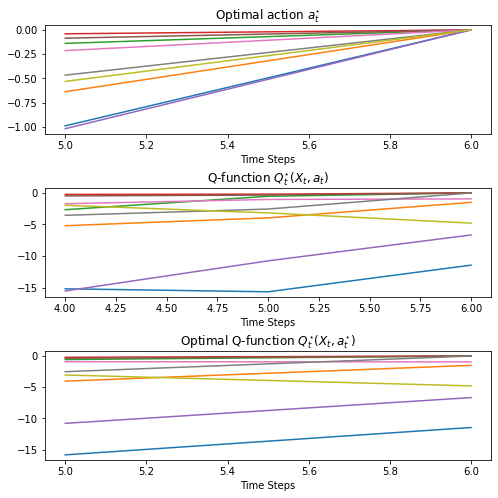

In [37]:
# plot both simulations
f, axarr = plt.subplots(3, 1)
f.subplots_adjust(hspace=.5)
f.set_figheight(8.0)
f.set_figwidth(8.0)

step_size = N_MC // 10
idx_plot = np.arange(step_size, N_MC, step_size)
axarr[0].plot(a_star.T.iloc[:, idx_plot]) 
axarr[0].set_xlabel('Time Steps')
axarr[0].set_title(r'Optimal action $a_t^{\star}$')

axarr[1].plot(Q_RL.T.iloc[:, idx_plot]) 
axarr[1].set_xlabel('Time Steps')
axarr[1].set_title(r'Q-function $Q_t^{\star} (X_t, a_t)$')

axarr[2].plot(Q_star.T.iloc[:, idx_plot]) 
axarr[2].set_xlabel('Time Steps')
axarr[2].set_title(r'Optimal Q-function $Q_t^{\star} (X_t, a_t^{\star})$') 

plt.savefig('QLBS_FQI_off_policy_summary_ATM_eta_%d.png' % (100 * eta), dpi=600)
plt.show()
